# Intro

이번 시간에는 긴 문장을 짧게 요약해주는 텍스트 요약기를 만들어보자.

**학습목표**
- Extractive/Abstractive summarization 이해하기
- 단어장 크기를 줄이는 다양한 text normalization 적용해보기
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

# What is Text Summarization?

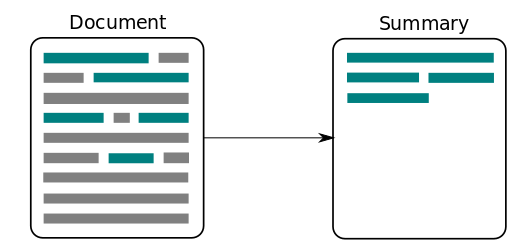

Text Summarization: the process of shortening a set of data computationally, to create a subset that represents the most important or relevant information within the original content.

이때 중요한 것은 요약 전후에 정보 손실 발생이 최소화되어야 한다는 점이다. 이렇게 요약 문장을 만들어내기 위해서는 크게 두 가지 접근으로 나누어볼 수 있는데, 이는 Extractive Summarization과 Abstractive Summarization이다.

## 1) 추출적 요약(Extractive Summarization)

단어 그대로 원문에서 **문장들을 추출해서 요약**하는 방식이다. 꺼내온 문장이 원문에서 중요한 문장일 수 있지만, 문장 간 연결이 자연스럽지 않을 수 있다. 딥러닝보다는 주로 텍스트 랭크와 같은 전통적인 머신러닝 알고리즘을 사용해 이 방법을 적용한다.

ex. 네이버 뉴스 서비스에 있는 `요약봇`

## 2) 추상적 요약(Abstractive Summarization)

원문으로부터 내용이 요약된 **새로운 문장을 생성**한다. 자연어 처리 분야 중 자연어 생성(NLG) 영역인 셈이다. 반면, 추출적 요약은 원문을 구성하는 문장 중 어느 것이 요약문에 들어갈 핵심문장인지를 판별한다는 점에서 문장 분류(Text Classification) 문제로 볼 수 있다.

>❓ RNN은 학습 데이터의 길이가 길어질수록 먼 과거의 정보를 현재에 전달하기 어렵다는 문제가 있다. 이를 해결하기 위해 LSTM, GRU가 등장했고, 그 이후로는 Attention 메커니즘이 등장했다. 이 문제의 이름은 뭘까?   
❗ 장기 의존성(long term dependencies) 문제

> [구글의 텍스트 요약 모델 관련 기사](http://www.zdnet.co.kr/view/?no=20160905114833&from=Mobile)   
❓ 텍스트마이닝 분야의 '역문서빈도' 같은 지표를 활용해 문서 내에서 중요해 보이는 부분을 추출해 요약문에 담는 방식을 쓸 때의 문제점을 무엇인가?   
❗ 원문에서 발췌하는 방식(Extractive summarization)의 요약 기법은 어색하거나 문법적으로 이상한 결과물을 만드는 문제가 있음

>❓ 구글이 짧은 문장, 요약문을 생성하는 모델을 딥러닝을 통해 end-to-end로 설계했다. 구글이 메일서비스에 적용한 자동 회신 기능을 만든 것과 비슷한 딥러닝 기법이며, 인코더와 디코더의 구조로 구성된 딥러닝 아키텍쳐의 이름은 무엇일까?    
❗ seq2seq(sequence-to-sequence)

# 인공 신경망으로 텍스트 요약 훈련시키기

seq2seq 모델을 통해 Abstractive summarization 방식의 텍스트 요약기를 만들어보자.

## 1) seq2seq 개요

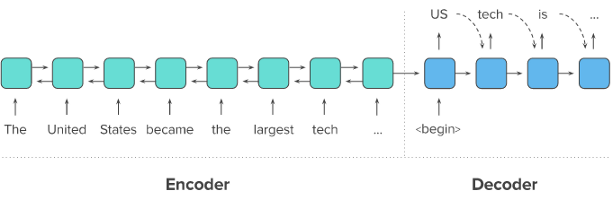

https://medium.com/dl-for-product-and-service/abstractive-text-summary-with-reinforcement-learning-ab2458ab29d5

원문을 첫 번째 RNN인 인코더로 입력하면, 인코더는 하나의 고정된 벡터로 변환한다. 이 벡터를 문맥 정보를 가진 벡터라고 하여 context vector라고 한다. 두 번째 RNN인 디코더는 context vector를 전달받아 한 단어씩 생성해서 요약 문장을 완성한다.

## 2) LSTM과 context vector

seq2seq를 구현할 때 인코더/디코더로 LSTM을 사용할 것이다.

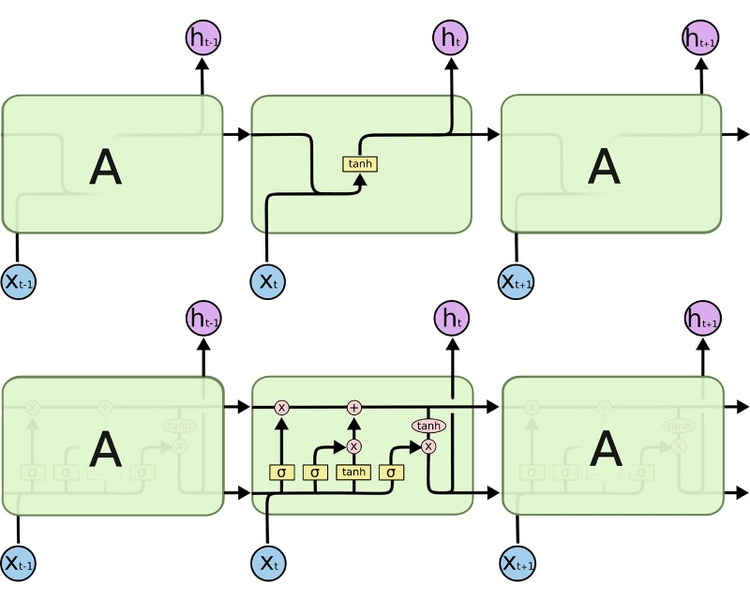

[RNN과 LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs)

LSTM이 바닐라 RNN과 다른 점은 다음 time step의 셀에 hidden state뿐만 아니라, cell state도 함께 전달한다는 점이다. 즉, 인코더가 디코더에 전달하는 컨텍스트 벡터 또한 hidden state h와 cell state c 두 개의 값 모두 존재해야 한다는 의미다.

## 3) start/end token
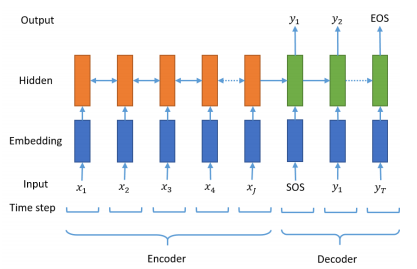

[시작 토큰 SOS와 종료 토큰 EOS는 각각 start of a sequence와 end of a sequence를 나타낸다](https://arxiv.org/pdf/1812.02303.pdf))

seq2seq 구조에서 디코더는 시작 토큰 SOS가 입력되면, 각 시점마다 단어를 생성하고 이 과정을 종료 토큰 EOS를 예측하는 순간까지 멈추지 않는다. 즉, 훈련 데이터의 예측 대상 시퀀스의 앞뒤에 토큰을 넣는 전처리를 통해 멈출 지점을 알려줘야 한다.

## 4) 어텐션 메커니즘을 통한 새로운 컨텍스트 벡터 사용하기

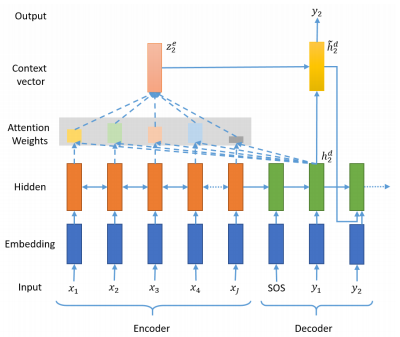

[기존의 컨텍스트 벡터보다 인코더의 정보를 적극적으로 활용하여 성능을 끌어올리는 어텐션 메커니즘](https://arxiv.org/pdf/1812.02303.pdf)

기존에 배운 seq2seq를 수정하고, 새로운 모듈을 붙여 모델의 성능을 높여보자. 기존 seq2seq는 인코더의 마지막 time step의 hidden state를 컨텍스트 벡터로 사용한다. 하지만 RNN 계열의 신경망의 한계로 인해 이미 컨텍스트 정보에는 입력 스퀀스의 많은 정보가 손실이 난 상태가 된다.

**하지만 Attention Mechanism은 인코더의 모든 step의 hidden state의 정보**가 컨텍스트 벡터에 전부 반영되게 한다. 디코더의 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산된다.

✔ 주의: 컨텍스트 벡터를 구성하기 위한 인코더 hidden state의 가중치 값은 **디코더의 현재 스텝의 위치에 따라 계속 변한다.** 즉, 디코더의 문장 생성 부위가 주어부/줄어부/목적어인지 등에 따라 인코더가 입력데이터를 해석한 컨텍스트 벡터가 다른 값이 된다는 것이다.

## 5) 정리

1. seq2seq를 사용합니다.
2. RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.
3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.
4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.
5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.
6. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.


# 데이터 준비하기

터미널을 열어 작업환경을 구성한다.

오늘 사용할 데이터셋은 `아마존 리뷰 데이터셋`이다.

[Reviews.csv.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/Reviews.csv.zip)

```
$ mkdir -p ~/aiffel/news_summarization/data
$ ln -s ~/data/*.csv ~/aiffel/news_summarization/data #클라우드 데이터 실행
```

이번 실습에서는 NLTK의 stopword를 사용할 것이다. NLTK를 설치하고 NTLK의 데이터셋을 다운로드하자.

NLTK(Natural Language ToolKit)은 영어 기호, 통계, 자연어 처리를 위한 라이브러리이다. 의미를 분석하고 요약하는 데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어 있다. NLTK 패키지에서 stopword dictionary를 다운로드하고, 데이터 전처리를 위한 나머지 패키지도 불러오자.

In [3]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')

from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# 시간상 10만개의 샘플만 사용하자

data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [5]:
# 전체 데이터 중 Summary / text 열만 훈련에 사용하기 때문에, 두 열만 별도로 저장

data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
42650,"Had high hopes for these, but alas, these bulb...","Unnatural, fluorescent quality of light"
90510,For about a week now I've checked all the loca...,"Thank you, Amazon.com"
97802,Teavana's Blueberry Kona Pop (w/rock sugar) ca...,Donna B
55745,"Jerky-type treat, too big for my Yorkshire Ter...","Great size, appeal, and food value for SMALL dogs"
85905,First and foremost I will say that I was sorel...,"Couscous, not Tabouli"
67772,I LOVE these chips! It is a little weird to r...,OooH Yummy!
44314,I never drink this tea alone. I always steep i...,Basically a laxative...
56956,I recently bought an espresso machine that had...,Lots of Tasty Fun
95914,I can't believe I found one food that works fo...,Three Happy Cats
71529,I have tried everything to help my milk chocol...,The perfect snack.


# 데이터 전처리하기 (1) 데이터 정리하기

전처리를 진행하자. null 데이터,  중복 데이터를 제거하자.

## 1) 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [7]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [9]:
# 데이터프레임의 drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거할 수 있다

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


중복이 제거되었다. 하지만 데이터 Null 값을 가지는 샘플이 있다면, drop_duplicates()가 null 값 한 개를 제외하고 지워줄 것이다.

이를 확인하기 위해 `.isnull().sum()`을 사용하자.

In [10]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [11]:
# dropna 함수로 Null을 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


## 2) 텍스트 정규화와 불용어 제거

**텍스트 정규화** 과정을 진행하여 기계의 연산량을 줄여주자.

[정규화 참고 사전](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [12]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [14]:
# NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거하자.

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

# 데이터 전처리 함수
## Text 전처리에서만 호출하고, Summary 전처리에서는 호출하지 않는다.
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [16]:
# Text를 전처리하고, 결과를 확인하기 위해 상위 5개 출력

clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [17]:
# Summary 전처리 시에는 불용어 제거를 'False'로 지정

clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


In [18]:
# 이후, 다시 한 번 empty sample이 생겼는지 확인해보기.(정제 과정에서 모든 단어가 사라지는 경우도 있음)

data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [19]:
# 빈 샘플을 확인후 제거하기

print(data.isnull().sum())

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

Text        0
Summary    70
dtype: int64
전체 샘플수 : 88355


# 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기

학습 진행을 위해 훈련데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해줘야 한다.

## 1) 샘플의 최대 길이 정하기

필요없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 훈련에 사용한 샘플의 최대 길이를 정해주자.

Text,Summary의 최소,최대,평균 길이를 구하고 길이 분포를 시각화해서 보자.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 50
텍스트의 평균 길이 : 24.113905010787324
요약의 최소 길이 : 1
요약의 최대 길이 : 8
요약의 평균 길이 : 3.4102221276854356


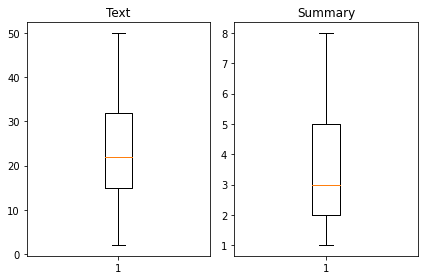

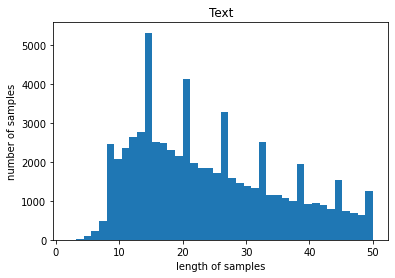

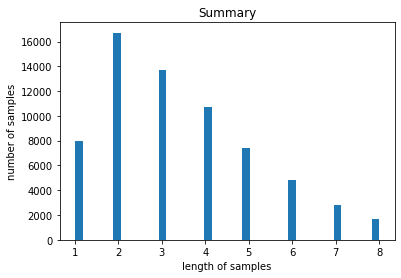

In [37]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위 그래프처럼, 많은 양의 데이터를 다룰 때는 데이터를 시각화하는 게 도움이 된다. 이 시각화한 데이터로부터 Text 최대 길이와 Summary의 적절한 최대 길이를 임의로 정하자.

In [38]:
text_max_len = 50
summary_max_len = 8
print('=3')

=3


In [39]:
# 50, 8로 지정했을 때, 객관적으로 데이터의 몇 %가 이에 해당하는지 계산해서 판단하자.

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

=3
전체 샘플 중 길이가 50 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 8 이하인 샘플의 비율: 1.0


In [40]:
# 정해진 길이보다 길면 제외하기

data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


## 2) 시작 토큰과 종료 토큰 추가하기

seq2seq훈련을 위해 디코더의 입력과 레이블에 시작 토근과 종료 토큰을 추가해야 한다.(sostoken, eostoken)

- `decoder_input` : 디코더 입력에 해당하며, 시작 토큰이 맨 앞에 있는 문장의 이름
- `decoder_target`: 디코더 출력에 해당하며, 종료 토큰이 맨 뒤에 붙는 문장의 이름    

In [41]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [42]:
# 인코더의 입력, 디코더의 입력 & 레이블을 다시 Numpy 타입으로 저장하기

encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [43]:
# 훈련/테스트 데이터 분리

## encoder_input과 크기/형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

## 만든 정수 시퀀스를 이용해 데이터의 샘플 순서를 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

## 데이터를 8:2 비율로 분리. 전체 데이터 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정한다.
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

## 정의한 테스트 데이터 개수를 이용해 전체 데이터를 split.
## : 표시의 위치에 주의!!

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[47900 61241   778 ... 25858 24553 43623]
=3
테스트 데이터의 수 : 13163
훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


# 데이터 전처리하기 (3) 정수 인코딩

## 1) 단어 집합(vocabulary) 만들기 및 정수 인코딩

기계가 텍스트를 숫자로 처리하도록 데이터의 단어들을 모두 정수로 바꿔야한다.(고유한 정수를 맵핑) 이 과정을 **단어집합(vocabulary)**을 만든다고 한다.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

In [44]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


단어 집합이 생성되고, 고유한 정수가 부여되었다. 생성된 단어 집합은 `src_tokenizer.word_index`에 저장되어 있다. 이 중 빈도수가 낮은 단어는 제외하고 진행하자.

`src_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장되어 있는데, 이를 통해 통계적인 정보를 얻을 수 있다.

In [45]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32039
등장 빈도가 6번 이하인 희귀 단어의 수: 23811
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8228
단어 집합에서 희귀 단어의 비율: 74.31879896376292
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4051462933937278


등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지한다. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않는다.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 한다. 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한해보자. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

In [46]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [47]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 단어들을 모두 정수로 변환한다(정수인코딩).
# 단어 집합의 크기를 8000으로 제한했으니, 8000이 넘는 숫자들은 정수 인코딩 후에는 존재하지 않는다.

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1537, 1090, 1783, 989, 1869, 643, 1771, 1463, 58, 2790, 102], [137, 89, 1993, 253, 3, 9, 3399, 1153, 121, 1898, 1402, 7201, 578, 3598, 3991, 1495], [212, 14, 123, 1110, 348, 177, 49, 162, 39, 405, 318, 2681, 49, 6, 538, 1143, 3292, 26, 6, 1136, 56, 421, 244]]
=3


In [48]:
# Summary 데이터에 대해서도 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')


# tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있다. 
# 이를 통해 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10491
등장 빈도가 5번 이하인 희귀 단어의 수: 8121
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2370
단어 집합에서 희귀 단어의 비율: 77.40920789247927
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.914596600915437


In [49]:
# 이전과 동일하게, 등장 빈도가 5회 이하인 단어들을 제거한다.
# 어림잡아 2000을 단어 집합의 크기로 제한한다.

tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 42, 9, 57], [1, 268, 1156], [1, 8, 113, 349], [1, 3, 7, 1548], [1, 29]]
target
decoder  [[42, 9, 57, 2], [268, 1156, 2], [8, 113, 349, 2], [3, 7, 1548, 2], [29, 2]]


정수 인코딩 작업이 끝났다. 하지만, 패딩으로 넘어가기 전에 점검해야 할 것이 있다. 바로 요약문에서 길이가 0이 된 샘플들을 삭제하는 것이다! `decoder_input`에는 `sostoken`, `decoder_token`에는 `eostoken`이 추가된 상태이고, 그렇기에 길이가 0이된 요약문의 실제 길이는 1로 나올 것이다. 이 점을 주의하여 코드를 수행하자.

In [50]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1257
삭제할 테스트 데이터의 개수 : 343
훈련 데이터의 개수 : 51398
훈련 레이블의 개수 : 51398
테스트 데이터의 개수 : 12820
테스트 레이블의 개수 : 12820


## 2) 패딩하기

정수 시퀀스로 변환이 되었다면, 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주어야 한다. 아까 정해둔 최대 길이로 패딩을 하자. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 맞춰준다.

In [51]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


# 모델 설계하기

## 1) 인코더 설계
함수형 API를 이용해서 인코더를 설계하자.

In [52]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터이다. 

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였다. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있다. 3개 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내져야 한다.

또한 LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용한다. 일반적인 dropout은 레이어의 weight를 `랜덤`으로 생략하여 모델의 과적합을 해결해준다. 반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이다. 즉, time step의 입력을 랜덤으로 생략해준다. recurrent dropout은 일반적인 dropout과 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다.

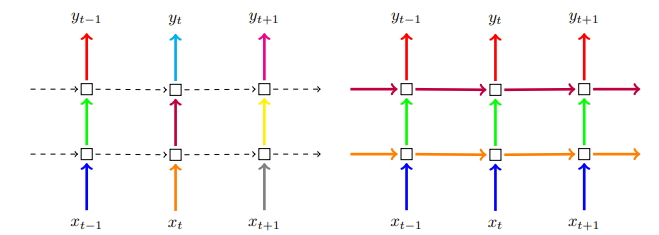

[dropout(왼쪽)과 dropout + recurrent dropout(오른쪽)](https://arxiv.org/pdf/1512.05287.pdf)

위 그림은 일반적인 dropout과 recurrent dropout을 동시에 사용한 것을 시각적으로 표현한 것이다. 색이 있는 화살표는 dropout을 나타낸 것이다. (참고: dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고도 한다.)

> 참고로 recurrent dropout을 사용하면 아래와 같은 경고문이 뜬다.
>``` 
WARNING:tensorflow:Layer lstm_15 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
> cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸린다.

[Recurrent Dropout에 대한 설명:Recurrent Dropout without Memory Loss](https://arxiv.org/pdf/1603.05118v2.pdf)


## 2) 이제 디코더를 설계해보자!

In [53]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더 임베딩 층과 LSTM을 설계하는 것은 거의 동일하나, **입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 한다.**

## 3) 이제 디코더의 출력층을 설계해보자.


In [54]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 4) 어텐션 메커니즘

Tensorflow에서 구현해둔 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워보자. 여기서의 어텐션 함수는 Bahdanau style의 어텐션이다.

[자세한 설명: 텐서플로우 홈페이지](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention)

아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해보자

In [56]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있다.

# 모델 훈련하기

## 1) 훈련 진행하기

In [58]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 142s 666ms/step - loss: 2.3673 - val_loss: 2.2697
Epoch 2/50
201/201 [==============================] - 132s 659ms/step - loss: 2.2251 - val_loss: 2.1659
Epoch 3/50
201/201 [==============================] - 131s 653ms/step - loss: 2.1138 - val_loss: 2.0695
Epoch 4/50
201/201 [==============================] - 130s 647ms/step - loss: 2.0296 - val_loss: 2.0070
Epoch 5/50
201/201 [==============================] - 130s 646ms/step - loss: 1.9653 - val_loss: 1.9682
Epoch 6/50
201/201 [==============================] - 130s 646ms/step - loss: 1.9113 - val_loss: 1.9338
Epoch 7/50
201/201 [==============================] - 130s 648ms/step - loss: 1.8656 - val_loss: 1.9101
Epoch 8/50
201/201 [==============================] - 130s 648ms/step - loss: 1.8253 - val_loss: 1.8975
Epoch 9/50
201/201 [==============================] - 130s 647ms/step - loss: 1.7902 - val_loss: 1.8743
Epoch 10/50
201/201 [==============================] - 130s 648m

`EarlyStopping`은 특정 조건이 충족되면 훈련을 멈춘다.

> es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

위 코드에서는 `val_loss`을 관찰하다가, 검층 데이터의 손실이 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추게 설계되어 있다!

[EarlyStopping 내용](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

## 2) 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

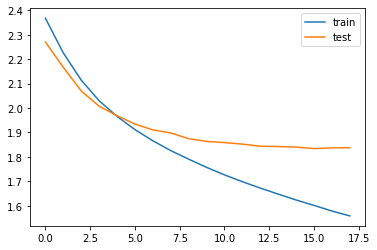

In [59]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해두자.

In [60]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련 때와 실제 동작(인퍼런스 단계)의 방식이 달라서, 그에 맞게 모델 설계를 별도로 진행해야 한다!

- 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, **인코더와 디코더를 엮은 통짜 모델 하나만 준비**했다.

- 하지만, 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장 길이만큼 디코더가 **반복 구조로 동작해야 하기 때문에, 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다. **

## 1) 인코더 설계

In [61]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


## 2) 어텐션 메커니즘을 사용하는 출력층 설계

In [62]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


## 3) 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기|

In [63]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


# 모델 테스트하기

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편할 것이다. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어보자. 함수를 만들 때, 

- Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고
- Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들자.

In [64]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [66]:
# 테스트 데이터 50개 샘플에 대한 실제 요약과 예측 요약 비교

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : makes tasty coffee drink every day smooth yet body among favorite keurig cup coffees 
실제 요약 : tasty 
예측 요약 :  great coffee


원문 : brought us mere taste cereals truly blessed lucky charms cinnamon toast crunch would throw man made attempt creating god given cereal 
실제 요약 : god eats this 
예측 요약 :  not as good as the same


원문 : taken drinking one black red rain morning one red red rain afternoon caffiene intake day replacing much expensive original hour energy subscription program think tastes better reason stopped addiction diet coke good advertised 
실제 요약 : great substitute for hour energy 
예측 요약 :  great for espresso


원문 : excited saw cracker jack box read review arrived one buy grocery store unfortunately cannot return also unhappy really wanted box cracker barrel sells genuine box know 
실제 요약 : am not happy 
예측 요약 :  not as described


원문 : tried alot asparagus far best enjoyed garlic spices lightly pickled variety excellant bloody mary vendor job done right also highly recomm

기존 요약과는 다른 요약을 출력하면서 원문 내용을 담고 있는 요약들이 종종 보인다.

추가적인 성능을 개선하기 위해서는

1. seq2seq와 어텐션 자체의 조합을 좀 더 좋게 수정하기
2. 빔 서치(beam search)
3. 사전 훈련된 워드 임베딩(pre-trained word embedding)
4. 인코더-디코더 자체의 구조를 새로이 변경하는 트랜스포머(Transformer)

와 같은 방법들이 있다.

# 추출적 요약 해보기

앞서 seq2seq2를 통해 추상적 요약을 진행했다.

이번엔 패키지 `Summa`에서 제공하는 모듈인 summarize를 통해 추출적 요약을 해보자. 영화 매트릭스 시놉시스를 요약해보자!

## 1) 패키지 설치

> $ pip list | grep summa


## 2) 데이터 다운로드

In [67]:
import requests
from summa.summarizer import summarize

In [68]:
# 매트릭스 시놉시스 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [69]:
# 일부만 출력해보고, 저장이 잘 되었는지 check
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

## 3) summarize 사용하기

> - text (str) : 요약할 테스트.
> - ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
> - words (int or None, optional) – 출력에 포함할 단어 수.
> - 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
> - split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

summarize는 문장 토큰화를 별도로 하지 않아도 내부적으로 문장 토큰화를 수행한다. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여보자.

In [71]:
# 원문의 0.005%만을 출력

print('Summary:')
print(summarize(text, ratio=0.005)) 

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [72]:
# 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 된다.
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [73]:
# 단어의 수로 요약문의 크기를 조절할 수도 있다. 
# 단어를 50개만 선택하도록 설정

print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


# 프로젝트: 뉴스기사 요약해보기

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

## Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

[sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

아래 코드로 다운로드할 수 있다.

In [77]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(len(data))

98401


In [76]:
# random data 10개 출력
data.sample(10)

,headlines,text
47014,"19-yr-old youngest no. 1 ODI bowler, breaks 21...",Afghanistan spinner Rashid Khan has become the...
20093,"40,000 people celebrate Ram Rahim's birthday w...","Over 40,000 Dera Sacha Sauda followers reporte..."
56376,Kings XI Punjab appoint ex-Aus batsman Hodge a...,Indian Premier League (IPL) franchise Kings XI...
74516,90 cows die in two more shelters run by arrest...,A day after Chhattisgarh BJP leader Harish Ver...
83205,Sheeran reacts to accusations of not singing l...,"Singer Ed Sheeran, responding to accusations o..."
42786,Israel admits bombing Syrian 'nuclear reactor'...,"After over 10 years of secrecy, Israel has for..."
24302,Woman in labour carried on cot through flooded...,A woman in labour was carried on a cot by her ...
4957,50 vehicles pile up on Haryana highway amid de...,"At least eight people, including seven from th..."
74034,Women's Health Line uses Sarahah to promote wo...,"Women's Health Line, an organisation which pro..."
16000,Delhi gets highest rainfall in September in 7 ...,Delhi this year has received the highest rainf...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

## Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [90]:
data.columns = ['Summary','Text']
data.sample(1)

,Summary,Text
25700,"Gayle almost drops catch with left hand, takes...",Vancouver Knights captain Chris Gayle pulled o...


### (1) 데이터 정리하기 
#### 1) 중복 샘플과 NULL 값 샘플 제거

In [91]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [92]:
# 데이터프레임의 drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거할 수 있다

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [97]:
# NULL 값이 있는지 체크
print(data.isnull().sum()) # 0

Summary    0
Text       0
dtype: int64


#### 2) 텍스트 정규화와 불용어 제거

In [99]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}
print("done")

done


In [100]:
# NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거하자.

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

# 데이터 전처리 함수
## Text 전처리에서만 호출하고, Summary 전처리에서는 호출하지 않는다.
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [101]:
# Text를 전처리하고, 결과를 확인하기 위해 상위 5개 출력

clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [102]:
# Summary 전처리 시에는 불용어 제거를 'False'로 지정

clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [103]:
# 이후, 다시 한 번 empty sample이 생겼는지 확인해보기.(정제 과정에서 모든 단어가 사라지는 경우도 있음)

data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [104]:
# 빈 샘플을 확인후 제거하기

print(data.isnull().sum())

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

Summary    0
Text       0
dtype: int64
전체 샘플수 : 98360


### (2) 훈련데이터와 데스트 데이터 나누기

#### 1) 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


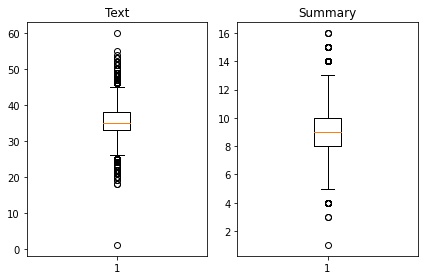

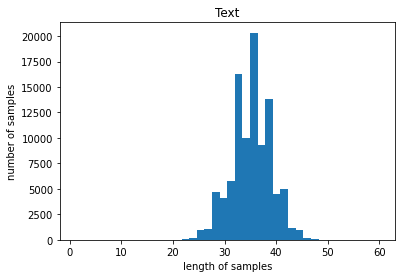

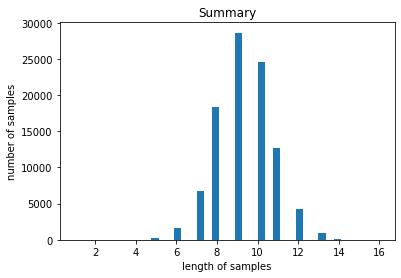

In [105]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [119]:
text_max_len = 37
summary_max_len = 10
print('=3')


=3


In [120]:
# 37, 10로 지정했을 때, 객관적으로 데이터의 몇 %가 이에 해당하는지 계산해서 판단하자.

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

=3
전체 샘플 중 길이가 37 이하인 샘플의 비율: 0.7378304188694591
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [121]:
# 정해진 길이보다 길면 제외하기

data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 58912


#### 2) 시작/종료 토큰 추가하기

In [122]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...
16,karan johar tabu turn showstoppers on opening ...,filmmaker karan johar actress tabu turned show...,sostoken karan johar tabu turn showstoppers on...,karan johar tabu turn showstoppers on opening ...


In [123]:
# 인코더의 입력, 디코더의 입력 & 레이블을 다시 Numpy 타입으로 저장하기

encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [124]:
# 훈련/테스트 데이터 분리

## encoder_input과 크기/형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

## 만든 정수 시퀀스를 이용해 데이터의 샘플 순서를 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

## 데이터를 8:2 비율로 분리. 전체 데이터 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정한다.
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

## 정의한 테스트 데이터 개수를 이용해 전체 데이터를 split.
## : 표시의 위치에 주의!!

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[54679 37077 42244 ... 54605 32708 54786]
=3
테스트 데이터의 수 : 11782
훈련 데이터의 개수 : 47130
훈련 레이블의 개수 : 47130
테스트 데이터의 개수 : 11782
테스트 레이블의 개수 : 11782


### (3) 정수 인코딩
#### 1) 단어 집합 만들기/정수 인코딩

In [125]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [126]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 54148
등장 빈도가 6번 이하인 희귀 단어의 수: 37383
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16765
단어 집합에서 희귀 단어의 비율: 69.038560981015
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.846471156454651


In [127]:
src_vocab = 16000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 16,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [128]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 단어들을 모두 정수로 변환한다(정수인코딩).

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[43, 4890, 156, 1197, 5564, 76, 2349, 616, 186, 445, 5645, 13, 248, 505, 5565, 685, 37, 24, 86, 4890, 561, 1223, 224, 246, 1160, 2289, 119, 339, 4707, 5, 460, 701, 285, 24, 38], [255, 4057, 474, 1190, 3599, 1099, 1486, 16, 20, 118, 389, 11258, 1, 560, 3000, 78, 119, 1, 3599, 1025, 2103, 474, 119, 312, 35, 1, 145, 474, 3254, 1099, 1770, 4836, 1061], [534, 760, 4172, 12, 29, 2453, 2082, 2511, 437, 89, 193, 90, 866, 5842, 476, 291, 5842, 871, 3867, 9965, 1, 534, 2096, 653, 6828, 2082, 3823, 3791]]


In [133]:
# Summary 데이터에 대해서도 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')


# tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있다. 
# 이를 통해 등장 빈도수가 5회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

=3
단어 집합(vocabulary)의 크기 : 24778
등장 빈도가 4번 이하인 희귀 단어의 수: 15895
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8883
단어 집합에서 희귀 단어의 비율: 64.14964888207281
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.8893132985120715


In [134]:
# 이전과 동일하게, 등장 빈도가 4회 이하인 단어들을 제거한다.
# 어림잡아 8000을 단어 집합의 크기로 제한한다.

tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 21, 14, 3, 4148, 141, 5, 291, 3758, 1760], [1, 116, 3943, 20, 3, 547, 769, 360, 3944, 82, 63], [1, 208, 4149, 25, 5, 39, 80, 7, 1339, 2694], [1, 2597, 6488, 1250, 4, 1079, 9, 2291, 5, 49], [1, 364, 6, 1711, 2292, 3463, 5986, 5987, 174]]
target
decoder  [[21, 14, 3, 4148, 141, 5, 291, 3758, 1760, 2], [116, 3943, 20, 3, 547, 769, 360, 3944, 82, 63, 2], [208, 4149, 25, 5, 39, 80, 7, 1339, 2694, 2], [2597, 6488, 1250, 4, 1079, 9, 2291, 5, 49, 2], [364, 6, 1711, 2292, 3463, 5986, 5987, 174, 2]]


In [135]:
# 길이가 1인 요약문 삭제

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 47130
훈련 레이블의 개수 : 47130
테스트 데이터의 개수 : 11781
테스트 레이블의 개수 : 11781


#### 2) 패딩

In [136]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### 1) 인코더 설계

In [137]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 2) 디코더 설계

In [138]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### 3) 출력층 설계

In [139]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 37, 128)      2048000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 37, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 4) 어텐션 메커니즘

In [140]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 37, 128)      2048000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 37, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 5) 모델 훈련하기

In [141]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
185/185 [==============================] - 103s 516ms/step - loss: 6.2755 - val_loss: 5.8845
Epoch 2/50
185/185 [==============================] - 93s 505ms/step - loss: 5.7514 - val_loss: 5.5416
Epoch 3/50
185/185 [==============================] - 93s 505ms/step - loss: 5.4415 - val_loss: 5.3224
Epoch 4/50
185/185 [==============================] - 94s 506ms/step - loss: 5.2047 - val_loss: 5.1596
Epoch 5/50
185/185 [==============================] - 94s 510ms/step - loss: 4.9985 - val_loss: 5.0129
Epoch 6/50
185/185 [==============================] - 94s 506ms/step - loss: 4.8107 - val_loss: 4.8803
Epoch 7/50
185/185 [==============================] - 94s 506ms/step - loss: 4.6404 - val_loss: 4.7914
Epoch 8/50
185/185 [==============================] - 94s 510ms/step - loss: 4.4864 - val_loss: 4.6974
Epoch 9/50
185/185 [==============================] - 94s 507ms/step - loss: 4.3483 - val_loss: 4.6152
Epoch 10/50
185/185 [==============================] - 93s 505ms/step - 

### 6) train, val dataset의 loss를 시각화

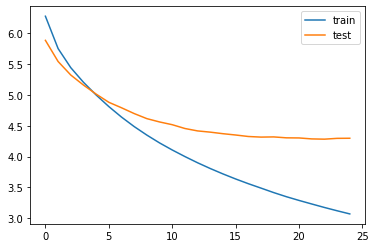

In [142]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

### (1) 인퍼런스 모델 구현하기
#### 1) 인코더 설계

In [143]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


#### 2) 어텐션 메커니즘을 사용한 출력층 설계

In [144]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


#### 3) 단어 시퀀스를 완성하는 함수 생성

In [145]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


#### 4) 모델 테스트

In [146]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [151]:
# 테스트 데이터 50개 샘플에 대한 실제 요약과 예측 요약 비교

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : think bout lights away notes cooler overpowering smell taste shipping opened excelent recomend avoid hand benefits gin filet emails unhappy clump heavy full otherwise room make good advertised fact smile hand excelent 
실제 요약 : alternatives about way link forming great yuk flavorful good and 
예측 요약 :  everlasting tip great horrible good cooking chocolate


원문 : think four supermarket however pumpkin purchase afraid several old tried food pouch sitting tomatoes one hanover several bars buy chew smell fda kefir four made purchase means pumpkin several curbed 
실제 요약 : stale great real sugar ounce good anything filled cooking chocolate 
예측 요약 :  stale chewing great of coffee pup wild


원문 : really longer bit persians pick dark im good amazon cup noticeable anxiously good amazon theatres calm life line hawaii buy loved change cookie consistent product awesome family ever root unfortunately want terrible lay peanuts taste 
실제 요약 : poor bowser one stuff presented lot 
예측 요약 :  these thumb

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

### 1) 데이터 다운로드

In [148]:
import requests
from summa.summarizer import summarize

### 2) summarize 사용하기

In [149]:
# 원문의 0.05%만을 출력

print('Summary:')
print(summarize(text, ratio=0.05)) 

Summary:
Anderson, a software engineer for a Metacortex, the other life as Neo, a computer hacker "guilty of virtually every computer crime we have a law for." Agent Smith asks him to help them capture Morpheus, a dangerous terrorist, in exchange for amnesty.
Trinity takes Neo to Morpheus.
Morpheus explains that he's been searching for Neo his entire life and asks if Neo feels like "Alice in Wonderland, falling down the rabbit hole." He explains to Neo that they exist in the Matrix, a false reality that has been constructed for humans to hide the truth.
Just before Neo passes out Morpheus says to him, "Welcome to the real world."
Neo is introduced to Morpheus's crew including Trinity; Apoc (Julian Arahanga), a man with long, flowing black hair; Switch; Cypher (bald with a goatee); two brawny brothers, Tank (Marcus Chong) and Dozer (Anthony Ray Parker); and a young, thin man named Mouse (Matt Doran).
Morpheus and Neo stand in a sparring program.
He asks Trinity why, if Morpheus thinks N

In [150]:
# 단어의 수로 요약문의 크기를 조절할 수도 있다. 
# 단어를 50개만 선택하도록 설정

print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


## Extractive 요약 vs Abstractive 요약

### 문법 완성도
확실히 추출적 요약에서 단어 간 연결이 자연스럽지 않고, 문법도 만족스럽지 못하다. 추상적 요약에서는 아무래도 문장/단어 자체를 새로 만들다보니 상대적으로 더 자연스러움을 확인할 수 있었다.

### 핵심 단어
핵심 단어 또한, 내가 느끼기에는 추상적 요약이 더욱 잘 표현한다는 느낌이 들었다.


# 회고

1. 이번 프로젝트에서 어려웠던 점   
- NLP에 대한 지식이 부족해서, 모델을 정확히 이해하는 게 어려웠다. 
- 인코더, 디코더 개념은 이해가 갔지만 특히나 어텐션 메커니즘을 이해하는 파트부터 정말 어렵게 다가왔다.
- keras를 이용해 모델을 쌓는 방식이 기존과 달라서 이해가 가지 않았다.

2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.   
- F-21노드에서 keras를 이용해 모델을 쌓는 3가지 방법을 배웠다. 따라서, 이 방법은 Functional API를 활용했다는 점을 배웠기 때문에 더욱 확실하게 이해하였다.
- 아직 샘플의 최대 길이를 어느 정도로 잡아야 하는지는 객관적으로 모르겠다. 사람 마음인 것 같게 느껴진다.
- tokenizer에 있는 word_index, word_counts.item() 등 여러 가지 함수들이 나오는데, keras가 익숙하지 않아서, 여러 함수들이 정보량으로 들어오는 게 적응하기 힘들다. 계속 공부를 하다보면 될 것 같다.

3. 루브릭 평가 지표를 맞추기 위해 시도한 것들   
- 분석, 정제, 정규화와 불용어 제거, 데이터셋 분리, 정수 인코딩 과정을 진행하였고, 데이터의 max길이를 적절하게 추정하여 좋은 결과를 얻었다.
- 모델이 안정적으로 EarlyStopping 되었고, 실제 요약문과 예측 요약문을 비교했을 때, 꽤나 괜찮게 나왔음을 확인하였다.
- Extractive 요약을 시도해 보고 Abstractive 요약 결과와 비교했다.

4. 자기다짐
- 설에 밀렸던 노드들을 끝냈다. 조금은 나태해진 나를 반성하고, 스터디 내용들도 빠짐없이 내것으로 만들어야겠다는 생각이 들었다.